# Face Recognition Using Siamese Network

We will understand the siamese network by building the face recognition model. The objective of our network is to understand whether two faces are similar or dissimilar. We use AT & T's the Database of Faces which can be downloaded from here (https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)

Once you have downloaded and extracted the archive, you can see the folders like s1, s2 up to s40 as shown here:

In [239]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [401]:
import time, os

import numpy as np

from tensorflow.python.keras.backend import sigmoid
from tensorflow.python.keras import models, optimizers, losses, activations, callbacks

from tensorflow.python.keras.datasets import mnist
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

Now, we define another function get_data for generating our data. As we know, for the Siamese network, data should be in the form of pairs (genuine and imposite) with a binary label.

First, we read the images (img1, img2) from the same directory and store them in the x_genuine_pair array and assign y_genuine to 1. Next, we read the images (img1, img2) from the different directory and store them in the x_imposite pair and assign y_imposite to 0.

Finally, we concatenate both x_genuine_pair, x_imposite to X and y_genuine, y_imposite to Y:

In [285]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.concatenate([x_train, x_test])
y_train = np.concatenate([y_train, y_test])

X = np.zeros((a, 2, b, c, 1))
Y = np.zeros((a, 1))

a, b, c = x_train.shape
indices = list(range(len(x_train)))

np.random.shuffle(indices)
order1 = indices.copy()
X[:, 0] = x_train[indices].reshape(a, b, c, 1) / 255

np.random.shuffle(indices)
order2 = indices.copy()
X[:, 1] = x_train[indices].reshape(a, b, c, 1) / 255

Y[:, 0] = ((y_train[order1] == y_train[order2]).astype(np.int8) + 1) % 2

In [286]:
size = len(Y[Y[:, 0] == 0])

indices = list(range(2*size))
np.random.shuffle(indices)

X = np.concatenate([X[Y[:, 0] == 1][:size], X[Y[:, 0] == 0]])[indices]
Y = np.concatenate([Y[Y[:, 0] == 1][:size], Y[Y[:, 0] == 0]])[indices]

In [288]:
X.shape

(13938, 2, 28, 28, 1)

In [289]:
Y.shape

(13938, 1)

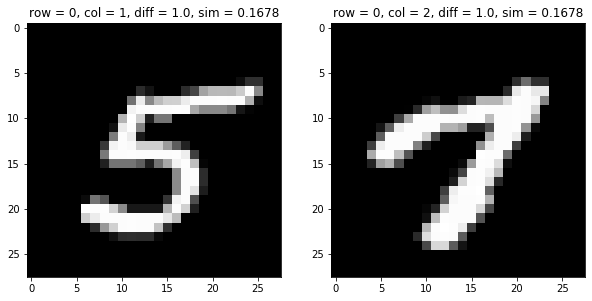

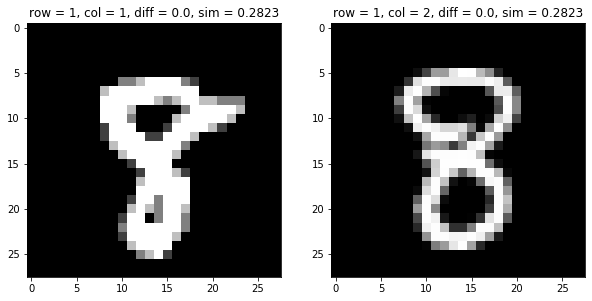

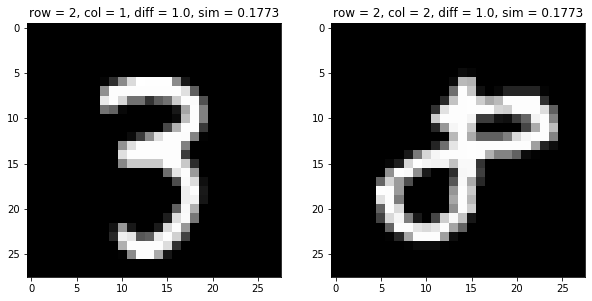

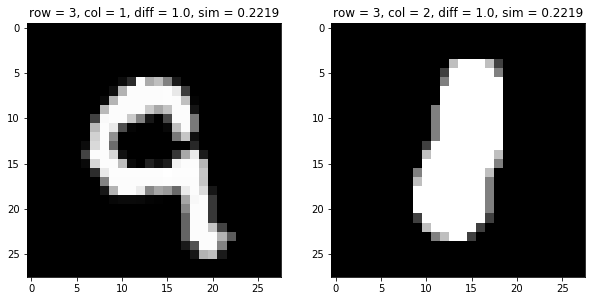

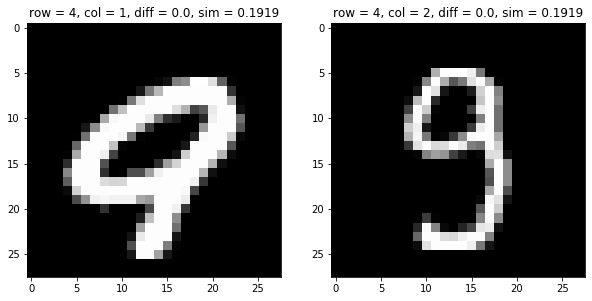

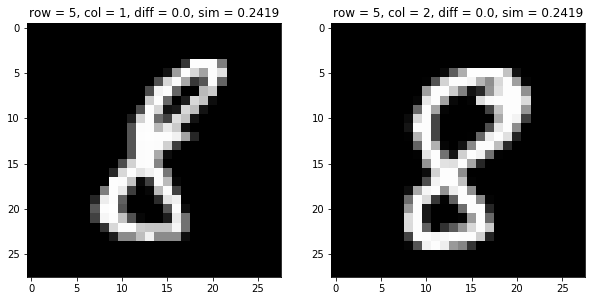

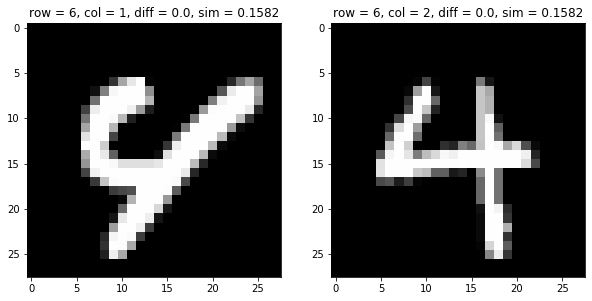

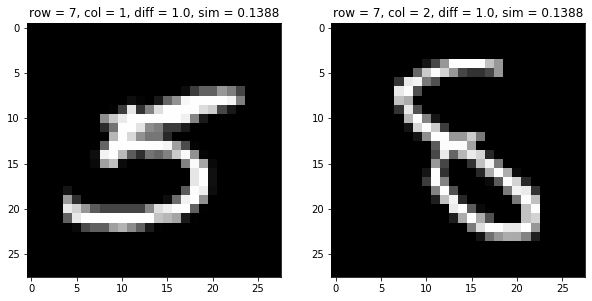

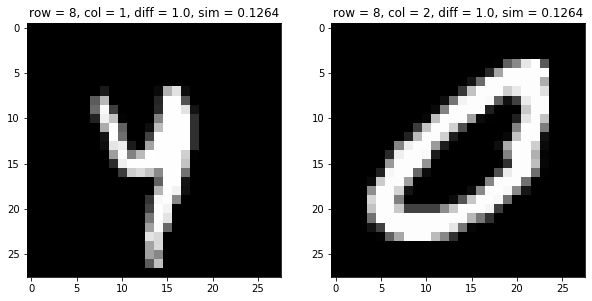

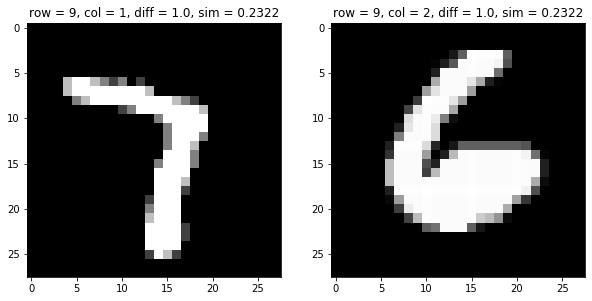

In [290]:
st, end = 0, 10
for index, images in enumerate(X[st:end]):
    fig=plt.figure(figsize=(10, 10))
    for k in range(1, 3):
        ax = fig.add_subplot(1, 2, k)
        ax.set_title(f'row = {index+st}, col = {k}, diff = {Y[index+st][0]}, sim = {get_similarity(images[0, :, :, 0], images[1, :, :, 0]):.4f}')

        plt.imshow(images[k-1, :, :, 0], cmap='gray', vmin=0, vmax=1)
    plt.show()

In [291]:
image_index = 70

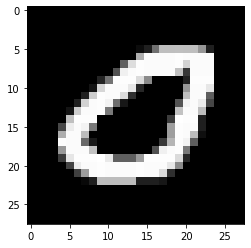

In [292]:
plt.imshow(X[image_index, 0, :, :, 0], vmin=0, vmax=1, cmap='gray')

Next, we split our data for training and testing with 75% training and 25% testing proportions:

In [293]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [297]:
x_train.shape, x_test.shape

((10453, 2, 28, 28, 1), (3485, 2, 28, 28, 1))

Now that, we have successfully generated our data, we build our siamese network. First, we define the base network which is basically a convolutional network used for feature extraction. We build two convolutional layers with rectified linear unit (ReLU) activations and max pooling followed by flat layer.

Next, we feed the image pair, to the base network, which will return the embeddings that is, feature vectors:

In [406]:
class Recognizer (object) :

    def __init__( self ):

        tf.logging.set_verbosity( tf.logging.ERROR )

        self.__DIMEN = 28
        depth = 1
        
        input_shape = ( self.__DIMEN, self.__DIMEN, depth)
        
        kernel_size_1 = ( 4 , 4 )
        kernel_size_2 = ( 3 , 3 )
        
        pool_size_1 = ( 3 , 3 )
        pool_size_2 = ( 2 , 2 )
        strides = (1, 1)
        
        #initialize model
        seq_model = tf.keras.Sequential()
        
        seq_model.add(Conv2D( 32, kernel_size=kernel_size_1 , strides=strides , activation=swish, input_shape=input_shape))
        seq_model.add(Conv2D( 32, kernel_size=kernel_size_1, strides=strides, activation=swish))
        seq_model.add(MaxPooling2D(pool_size=pool_size_1, strides=strides ))
        
        seq_model.add(Conv2D( 64, kernel_size=kernel_size_2 , strides=strides , activation=swish ))
        seq_model.add(Conv2D( 64, kernel_size=kernel_size_2 , strides=strides , activation=swish ))
        seq_model.add(MaxPooling2D(pool_size=pool_size_2 , strides=strides))
        
        seq_model.add(Flatten())
        seq_model.add(Dense( 64 , activation=activations.sigmoid ))

        input_x1 = Input( shape=input_shape )
        input_x2 = Input( shape=input_shape )
        
        output_x1 = seq_model( input_x1 )
        output_x2 = seq_model( input_x2 )

        distance_euclid = Lambda( lambda tensors : K.abs( tensors[0] - tensors[1] ))( [output_x1 , output_x2] )
        outputs = Dense( 1 , activation=activations.sigmoid) ( distance_euclid )
        
        self.__model = models.Model( [ input_x1 , input_x2 ] , outputs )
        self.__model.compile( loss=losses.binary_crossentropy , optimizer=optimizers.Adam(lr=0.0001))


    def fit(self, X, Y ,  hyperparameters  ):
        initial_time = time.time()
        self.__model.fit( X, Y,
             batch_size=hyperparameters[ 'batch_size' ] ,
             epochs=hyperparameters[ 'epochs' ] ,
             callbacks=hyperparameters[ 'callbacks'],
             validation_split=hyperparameters[ 'validation_split' ]
         )
        
        final_time = time.time()
        eta = ( final_time - initial_time )
        time_unit = 'seconds'
        if eta >= 60 :
            eta = eta / 60
            time_unit = 'minutes'
        print( 'Elapsed time acquired for {} epoch(s) -> {} {}'.format( hyperparameters[ 'epochs' ] , eta , time_unit ) )


    def prepare_images_from_dir( self , dir_path , flatten=True ) :
        images = list()
        images_names = os.listdir( dir_path )
        for imageName in images_names :
            image = Image.open(dir_path + imageName)
            resize_image = image.resize((self.__DIMEN, self.__DIMEN))
            array = list()
            for x in range(self.__DIMEN):
                sub_array = list()
                for y in range(self.__DIMEN):
                    sub_array.append(resize_image.load()[x, y])
                array.append(sub_array)
            image_data = np.array(array)
            image = np.array(np.reshape(image_data,(self.__DIMEN, self.__DIMEN, 3)))
            images.append(image)

        if flatten :
            images = np.array(images)
            return images.reshape( ( images.shape[0]  , self.__DIMEN**2 * 3  ) ).astype( np.float32 )
        
        else:
            return np.array(images)



    def evaluate(self , test_X , test_Y  ) :
        return self.__model.evaluate(test_X, test_Y)


    def predict(self, X  ):
        predictions = self.__model.predict( X  )
        return predictions


    def summary(self):
        self.__model.summary()

    def save_model(self , file_path ):
        self.__model.save(file_path )


    def load_model(self , file_path ):
        self.__model = models.load_model(file_path)

In [409]:
width, height, depth = 28, 28, 1
n = -1

X1 = x_train[:, 0].astype( np.float32 )[:n]
X2 = x_train[:, 1].astype( np.float32 )[:n]
XY = y_train[:n]

print( X1.shape )
print( X2.shape )
print( XY.shape )

(10452, 28, 28, 1)
(10452, 28, 28, 1)
(10452, 1)


## Initialize model

In [410]:
recognizer = Recognizer()
print(recognizer._Recognizer__model.summary())

#recognizer.load_model('models/model.h5')

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_40 (Sequential)      (None, 64)           994048      input_61[0][0]                   
                                                                 input_62[0][0]                   
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 64)           0           sequential_40[1][0]       

## Fit model to data

In [411]:
parameters = {
    'batch_size' : 8,
    'epochs' : 8,
    'callbacks' : None , # [ TensorBoard( log_dir='logs/{}'.format( time.time() ) ) ] ,
    'validation_split' : .25
}

recognizer.fit( [ X1 , X2 ], XY, hyperparameters=parameters)
recognizer.save_model('models/model.h5')

Train on 7839 samples, validate on 2613 samples
Epoch 1/8
7839/7839 [==============================] - 171s 22ms/sample - loss: 0.5645 - val_loss: 0.5037
Epoch 2/8
7839/7839 [==============================] - 182s 23ms/sample - loss: 0.4538 - val_loss: 0.4266
Epoch 3/8
1264/7839 [===>..........................] - ETA: 2:33 - loss: 0.4070

E1231 17:12:29.653329  8112 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



## Test model

In [ ]:
prediction = recognizer.predict( [ x_test[:, 0] , x_test[:, 1]])

In [ ]:
accuracy = 0
for index, actual in enumerate(y_test[:, 0]):
    predicted = prediction[index][0]
    
    score = int(int(predicted > 0.5) == actual)
    accuracy += score
    
    if not score:
        print(f"prediction = {predicted:.4f}, actual = {actual}")
    
print(f"accuarcy = {accuracy / len(y_test):.4f}")